##  Optimze and a Dense Neural Network for gap filling and feature identification

** With a few tweaks to RepRunner, an LSTM can be run instead

In [6]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
# from functools import partial
from multiprocessing import Pool
from sklearn import metrics
# from sklearn.model_selection import train_test_split

## Personal Modules
import ReadStandardTimeFill as RSTF
import importlib
import DenseNet as Dense
import MiscFuncs as MF
importlib.reload(Dense)
importlib.reload(RSTF)
importlib.reload(MF)

# %matplotlib inline

%matplotlib notebook
%config IPCompleter.greedy=True

from scipy.optimize import minimize, curve_fit
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from matplotlib import cm

from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

from ipywidgets import FloatProgress
from IPython.display import display
import os  
from functools import partial
import shutil
from keras import backend as K
try:pool.close()
except:pass


def Test(params,X,y,YScaled,XScaled,pool):
    return(np.random.rand(params['K']))


def ModSelect(Scope,Site):
    if Site == 'Illisarvik':
        if Scope == 'Full':
            Model = ['H','wind_speed','air_pressure','PPFD_Avg','AirTC_Avg','VPD',
                    'Temp','VWC','Sedge','Shrub','Grass','Sparse','Out_of_Basin']
        if Scope == 'Test':
            Model = ['PPFD_Avg','wind_speed']#,'Temp','VWC','Sedge']
    if Site == 'FishIsland':
        BaseFactors = []
        if Scope == 'Full':
            Model = ['H','Wind Spd','air pressure','Ta','Rn','PPFD','Rain','Water Table',
            'Ts 2.5 cm','Ts 15 cm','VWC','Active Layer','24H Rain','Wtr Tbl Trnd']
        if Scope == 'Test':
            Model = ['H','Water Table','Wind Spd','Active Layer']
    return(Model)

def Combos(Model,L,factor=None):
    Models=[]
    for c in combinations(Model,L):
        c = list(c)
        if factor is None:
            Models.append(c)
        else:
            for f in factor:
                f = f.split('+')
                if set(f).issubset(set(c)) and c not in Models:
                    Models.append(c)
                    
    print('Models: ',Models)
    return(Models)

def Stats(mse,j,i,params):
    df = pd.DataFrame(index = [str(j)+'_'+str(i)],
                      data={'Model':[params['Model']],
                            'MSE':[mse.mean()],
                            'SE':[mse.std()/params['K']**.5],
                            'Performance':0})
    return(df)

def t(p,n):
    alpha = 1-p
    df = n-1
    return(stats.t.ppf(alpha,df))


# Model

Models:  [['PPFD_Avg'], ['wind_speed']]
Saved model to disk


/home/ubuntu/NetworkAnalysis/DenseNet.py:169: RuntimeWarning: Mean of empty slice
  Y_hat_val_bar=np.nanmean(Y_hat_val,axis=0)


[        nan         nan         nan  0.44282621  0.34133804  0.43315855
  0.43420907         nan         nan         nan         nan  0.37603351
  0.33794224  0.40626684         nan  0.40797161  0.42101878         nan
  0.60818726         nan  0.51019597         nan         nan  0.39317819
  0.40623266  0.39145613         nan  0.47695972  0.5667395          nan
  0.54587591  0.7556929          nan         nan  0.47872734         nan
         nan  0.85662949  0.7503891   0.66125289         nan  0.39921451
         nan         nan  0.38249508         nan         nan  0.84929544
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
  0.43868938         nan  0.61878866  0.39227083  0.44591376  0.40335697
         nan         nan  0.3630634          nan         nan  0.35616374
         nan         nan         nan         nan  0.33679417         nan
         nan  0.37095276         nan         nan  0

/home/ubuntu/NetworkAnalysis/DenseNet.py:169: RuntimeWarning: Mean of empty slice
  Y_hat_val_bar=np.nanmean(Y_hat_val,axis=0)


[        nan         nan         nan  0.49840885  0.43207216  0.41721845
  0.52231389         nan         nan         nan         nan  0.53917426
  0.47400522  0.42559487         nan  0.47267236  0.49568519         nan
  0.43433082         nan  0.46887976         nan         nan  0.4894135
  0.48321053  0.51930624         nan  0.46320757  0.48372325         nan
  0.47505614  0.51465094         nan         nan  0.53561956         nan
         nan  0.4507494   0.47153866  0.40461142         nan  0.44174671
         nan         nan  0.54122722         nan         nan  0.45045385
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
  0.46109658         nan  0.33938113  0.38425297  0.46973725  0.43261039
         nan         nan  0.4380275          nan         nan  1.40580738
         nan         nan         nan         nan  0.60229897         nan
         nan  0.66661817         nan         nan  1.

/home/ubuntu/NetworkAnalysis/DenseNet.py:169: RuntimeWarning: Mean of empty slice
  Y_hat_val_bar=np.nanmean(Y_hat_val,axis=0)


[        nan         nan         nan  0.36372703  0.3727484   0.44279957
  0.46682683         nan         nan         nan         nan  0.25108841
  0.35042277  0.33847317         nan  0.37552199  0.42172483         nan
  0.65295416         nan  0.6059339          nan         nan  0.36120644
  0.362443    0.37096721         nan  0.51942554  0.37851104         nan
  0.78162664  0.79662549         nan         nan  0.3501147          nan
         nan  1.02229548  0.76755518  0.59334928         nan  0.40502554
         nan         nan  0.56912643         nan         nan  0.79226661
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
  0.42203006         nan  0.56244212  0.38570917  0.45046774  0.41774026
         nan         nan  0.28058597         nan         nan  0.59902841
         nan         nan         nan         nan  0.07794503         nan
         nan  0.58267266         nan         nan  0

<IPython.core.display.Javascript object>


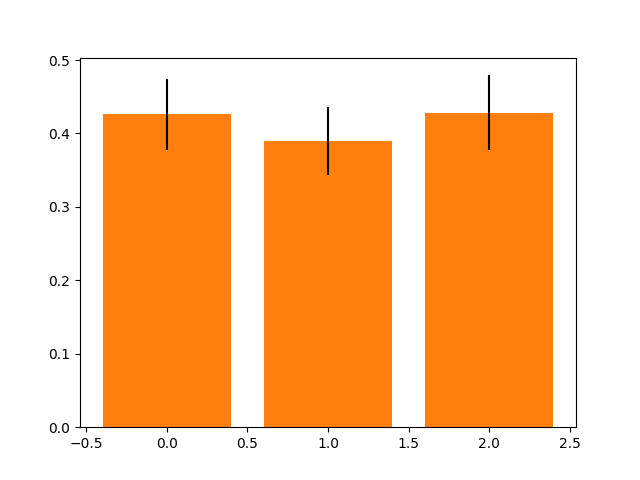

  index       MSE                Model  Performance        SE
0   1_0  0.425916             PPFD_Avg            2  0.048827
1   1_1  0.390027           wind_speed            2  0.046648
2   2_0  0.428233  PPFD_Avg+wind_speed            2  0.051168


In [7]:
MP=True
Scope = 'Test'
cwd = os.getcwd()
# for Site in ['Illisarvik','FishIsland']:
Site='Illisarvik'
target='fch4'

# params['Loss']='mean_absolute_error'

if __name__ == '__main__':
    XVarriables=ModSelect(Scope,Site)
    for j in range(1,len(XVarriables)+1):
        if j == 1:
            Inputs = (Combos(XVarriables,j))
        else:
            Inputs = (Combos(XVarriables,j,Factors))
        i = 0
        for Input in Inputs:
            params = Dense.Params(Scope,target,MP)
            params['Dpath'] = cwd+'/'+Site+'/'
            params['Spath'] = params['Dpath']+'/'+target+'/'+str(j)+'_'+str(i)+'/'
            try:
                os.mkdir(params['Spath'])
            except:
                pass
            params['Sname'] = 'Y_'
            params['Inputs'] = Input
            params['Model'] = '+'.join(params['Inputs'])

            RST = RSTF.ReadStandardTimeFill(params['Dpath']+'ECData.csv',resample='2H')
            RST.Scale(params['target'],params['Inputs'])
            y = RST.y*1.0
            X = RST.X*1.0

            params['N']=int(y.shape[0]/30)
#             mse = Test(params,X,y,RST.YScaled,RST.XScaled,pool)
            params['Memory'] = (math.floor(100/params['proc'])- 5/params['proc']) * .01
            Y_hat=[]
            y_true=[]
            X_true=[]
            index=[]
            ones=[]
            if MP == False:
                for k in range(params['K']):
                    results = Dense.TTV_Split(k,params,X,y)
                    Y_hat.append(RST.YScaled.inverse_transform(results[0]))
                    y_true.append(RST.YScaled.inverse_transform(results[1]))
                    X_true.append(RST.XScaled.inverse_transform(results[2]))
                    index.append(results[3])
                    ones.append(results[4])
            else:
                pool = Pool(processes=3,maxtasksperchild=75)
                for k,results in enumerate(pool.imap(partial(Dense.TTV_Split,params=params,X=X,y=y),range(params['K']))):
                    Y_hat.append(RST.YScaled.inverse_transform(results[0]))
                    y_true.append(RST.YScaled.inverse_transform(results[1]))
                    X_true.append(RST.XScaled.inverse_transform(results[2]))
                    index.append(results[3])
                    ones.append(results[4])
                pool.close()
                
#                 tf.keras.backend.clear_session()
            Y_hat = np.squeeze(np.asanyarray(Y_hat))
            y_true = np.squeeze(np.asanyarray(y_true))
            X_true = np.asanyarray(X_true)
            index = np.asanyarray(index)
            ones = np.asanyarray(ones)
            
            params['Memory'] = .95
            if MP == False:
                for k in range(1):
                     mse = Dense.Sort_outputs(k,params,Y_hat,y_true,X_true,index,ones)
            else:
                pool = Pool(processes=1,maxtasksperchild=75)
                for k,results in enumerate(pool.imap(partial(Dense.Sort_outputs,params=params,
                                                             Y_hat=Y_hat,y_true=y_true,X_true=X_true,index=index,ones=ones),
                                                     range(1))):
                     mse = results
                pool.close()
            
            if i == 0:
                Level = Stats(mse,j,i,params)
            else:
                Level = Level.append(Stats(mse,j,i,params))
            i += 1

        Min = Level.loc[Level['MSE']==Level['MSE']].min()
        T= t(0.05,params['K'])
        Factors = Level.loc[Level['MSE']<=Min['MSE']+Min['SE']*T,'Model'].values
        Level.loc[Level['MSE']<=Min['MSE']+Min['SE']*T,'Performance']=1
        print(Level)
        
        if j == 1:
            Records = Level
        else:
            Records = Records.append(Level)


Records = Records.reset_index()
plt.figure()
Min = Records.loc[Records['MSE']==Records['MSE']].min()
# print(Min['MSE']+Min['SE']*T)
Records.loc[Records['MSE']<=Min['MSE']+Min['SE']*T,'Performance']=2
T= t(0.05,params['K'])
Top = Records.loc[Records['Performance']==1]

Worst = Records.loc[Records['Performance']==0].index.values
# for rm in Worst:
#     shutil.rmtree(params['Dpath']+'/'+target+'/'+rm)
Best = Records.loc[Records['Performance']==2]#.reset_index()
# print(Best.index,Best['MSE'],Best['SE'])
plt.bar(Top.index,Top['MSE'],yerr=Top['SE'])
plt.bar(Best.index,Best['MSE'],yerr=Best['SE'])#,color='red')
print(Records)

# Sorting

# CI and PI

# Map Results

In [ ]:
Fill = False
if Fill == True:
    X = RST.X_fill
else:
    X = RST.X
print(X.shape)
params['Sname']='Test'
params['Loss']='mean_absolute_error'
Y_fill = []
Y_bar = []
MSE = []
for i in range(params['K']):
    params['iteration']=i
    Empty_Mod = Dense.Load_Model(params)
    Model = Dense.Load_Weights(Empty_Mod,params) 
    Y = RST.YScaled.inverse_transform(Model.predict(X).reshape(-1,1))
    Y_bar.append(RST.YScaled.inverse_transform(Model.predict(np.median(X,axis=0)).reshape(-1,1)))
    if Fill == False:
        mse = (metrics.mean_squared_error(RST.y,Y))
        MSE.append(mse)
    Y_fill.append(Y)
Y_fill = np.asanyarray(Y_fill).mean(axis=-1)
Y_bar = np.asanyarray(Y_bar).mean(axis=-1)
Y_fill_bar = Y_fill.mean(axis=0)
Y_bar = Y_bar.mean(axis=0)
if Fill == False:
    MSE = np.asanyarray(MSE)
    CI = stats.t.ppf(1-0.025,i)*MSE.std()/(i)**.5
    print(CI)
    
print(Y_bar,Y_fill_bar.mean())

params['Sname']='Var'
params['iteration']=1
params['Loss']='Boot_Loss'
Empty_Mod = Dense.Load_Model(params)
Model = Dense.Load_Weights(Empty_Mod,params) 
YVar=YScaled.inverse_transform(Model.predict(X).reshape(-1,1))
YVar_bar=YScaled.inverse_transform(Model.predict(X.mean(axis=0)).reshape(-1,1))
X_back = np.squeeze(RST.XScaled.inverse_transform(X))

print(RST.YScaled.inverse_transform(RST.y).shape,np.squeeze(Y_fill_bar).shape)

Data = pd.DataFrame(data=X_back,columns=params['Inputs'])
Data[target] = np.squeeze(Y_fill_bar)
Data['True'] = RST.Master[target]#.YScaled.inverse_transform(RST.y)
Data['SE'] = 1/(params['K']-1)*((Y_fill-Y_fill_bar)**2).sum(axis=0)
Data['Var'] = np.squeeze(YVar)
Data['CI']=stats.t.ppf(1-0.025,params['K'])*(Data['SE'])**.5
Data['PI']=stats.t.ppf(1-0.025,params['K'])*((Data['Var']+Data['SE'])**.5) #the accuracy of our estimate with respect to the observed output

print(Data['CI'].mean())
print(Data[target].mean())
print(Data['True'].mean())
Data['Fill'] = Data['True'].fillna(Data[target])
print(Data['Fill'].mean())

# plt.figure(figsize=(8,7))
# Data = Data.sort_values(by='PPFD_Avg')
# Data.index = Data.PPFD_Avg


# plt.scatter(Data.index,Data['True'],edgecolor='black',facecolor='white')
# plt.plot(Data.index,Data[target],label=
#         params['target']+' Model\nRMSE: '+str(np.round(metrics.r2_score(Data['True'],
#                                                                    Data[params['target']])**2,3)))
# # plt.plot(Data.index,Data['Var'],label= params['target']+
# # ' Model\nRMSE: '+str(np.round(metrics.mean_squared_error(Data['True'],
# #                                                                    Data[params['target']])**2,3)))


# plt.fill_between(Data.index, Data[target]-Data['PI'], 
#                  Data[target]+Data['PI'],  color = 'green', alpha = 0.4, 
#                  label = '95% PI')
# plt.fill_between(Data.index, Data[target]-Data['CI'], 
#                  Data[target]+Data['CI'],  color = 'red', alpha = 0.4, 
#                  label = '95% CI')
# plt.legend()

# The "Optimum" Sized Model

In [ ]:
# pool.close()
# Site = 'Illisarvik'#'FishIsland'#
Scope = 'Test'
cwd = os.getcwd()

# def Params(Func,Y,MP = True):
#     params = {}
#     params['proc']=3
#     if MP == False:
#         params['proc']=1
#     if Func == 'Full':
#         epochs = 200
#         K = 30
#         splits_per_mod = 1
#         N = np.linspace(200,20,10,dtype='int32')
#     elif Func == 'Test':
#         epochs = 200
#         K = 30
#         splits_per_mod = 1
#         N = np.linspace(70,10,5,dtype='int32')
#     N = np.repeat(N,K)
#     d = {'N':N.astype(int)}
#     Runs = pd.DataFrame(data=d)
#     Runs['MAE'] = 0.0
#     Runs['R2'] = 0.0
#     Runs['Model']=0
#     params['K'] = K
#     params['epochs'] = epochs
#     params['Y'] = Y
#     params['splits_per_mod'] = splits_per_mod
#     params['Save'] = {}
#     params['Save']['Weights']=False
#     params['Save']['Model']=False
    
#     return(Runs,params)


# MP=False

# if Scope == 'Full':
#     MP = True
# if __name__=='__main__'and MP==True:
#     pool = Pool(processes=3,maxtasksperchild=75)
# else:pool=None
    
# # for Site in ['Illisarvik','FishIsland']:
# Site='Illisarvik'
# FillVar = 'fco2'
# #     for FillVar in ['fco2','fch4']:
# Runs,params = MF.Params(Scope,FillVar,MP)
# FullModel = ModSelect(Scope,Site)
# print(FullModel)
# params['Dpath'] = cwd+'/'+Site+'/'
# params['Prelim_N']=True
# Best,Scores,ModelRuns = MF.FactorTest(params,FullModel,Runs)
# print(Best,Scores)
# Scores,ModelRuns = Best_Fill(Best,Runs,Scores,params)
# Scores.to_csv(params['Dpath']+FillVar+'/GapFillingSummary.csv')
# ModelRuns.to_csv(params['Dpath']+FillVar+'/GapFilled.csv')

# if __name__=='__main__'and MP==True:
#     pool.close()

In [ ]:
# Grp = Scores.groupby('Model').mean()
# Grp['SE'] = Scores[['Model','MAE']].groupby('Model').sem()
# # Grp['SE'] = Scores[['Key','MAE']].groupby('Key').sem()
# print(Grp)
# # plt.bar(Grp.index,Grp['MAE'],yerr=Grp['SE'])

In [ ]:
print('kitty')